## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import math

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", valid=False, normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        
        inps = []#np.array([])
        out =  []#np.array([])
        for i in range(inputs.shape[0]):
            inp = np.concatenate([(inputs[i, :, 0] - inputs[i, 0, 0]).reshape(50, 1),
                                  (inputs[i, :, 1] - inputs[i, 0, 1]).reshape(50, 1)], axis=1)
            o = np.concatenate([(outputs[i, :, 0] - inputs[i, 0, 0]).reshape(60, 1),
                                (outputs[i, :, 1] - inputs[i, 0, 1]).reshape(60, 1)], axis=1)
            inps.append(inp)#np.append(inps,inp)
            out.append(o)#np.append(out,o)
            #inps = np.vstack((inps,inp))
            #out = np.vstack((out,o))
        
        inps = np.array(inps)
        out = np.array(out)
             
        if valid:
            idx = int(len(inputs) * .8)
            return inps[:idx], inps[idx:], out[:idx], out[idx:]
        else:
            return inps, out
#   else: 
#         inps = []#np.array([])
#         for i in range(inputs.shape[0]):
#             inp = np.concatenate([(inputs[i, :, 0] - inputs[i, 0, 0]).reshape(50, 1), (inputs[i, :, 1] - inputs[i, 0, 1]).reshape(50, 1)], axis=1)
#             inps.append(inp)
#         inps = np.array(inps)

    return inputs, None

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        if self.split == 'train':
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = (self.inputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data
    
class ValidationDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, inputs, outputs, transform=None):
        super(ValidationDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = inputs, outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

##get_city_trajectories()

## Create a DataLoader class for training

In [3]:
batch_sz = 32  # batch size 
train_loader = DataLoader(train_dataset, batch_size=batch_sz)

## Sample a batch of data and visualize 

In [4]:
import matplotlib.pyplot as plt
# import random

# def show_sample_batch(sample_batch):
#     """visualize the trajectory for a batch of samples"""
#     inp, out = sample_batch
#     batch_sz = inp.size(0)
#     agent_sz = inp.size(1)
    
#     fig, axs = plt.subplots(1, batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
#     fig.subplots_adjust(hspace = .5, wspace=.001)
#     axs = axs.ravel()   
#     for i in range(batch_sz):
#         axs[i].xaxis.set_ticks([])
#         axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
#         axs[i].scatter(inp[i,:,0], inp[i,:,1])
#         axs[i].scatter(out[i,:,0], out[i,:,1])

        
# for i_batch, sample_batch in enumerate(train_loader):
#     # inp[i] is a scene with 50 coordinates, input[i, j] is a coordinate
#     # gotta loop through each scene in the batch
#     inp, out = sample_batch # inp: (batch size, 50, 2), out: (batch size, 60, 2)
#     """
#     TODO:
#       implement your Deep learning model
#       implement training routine
#     """
#     show_sample_batch(sample_batch)
#     break

In [5]:
# from d2l.ai
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, device, dropout=0):
        super(RNN, self).__init__()
        self.device = device
        self.rnn = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=n_layers, 
            dropout=dropout, 
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.to(self.device)
#         self.rnn.flatten_parameters()
                        
        out, (hn, cn) = self.rnn(x)
        
        print(out)
        
        o = hn[-1]
        
        print(self.fc(o))
        print(self.fc(o).size())

                        
        return self.fc(out)
    
    
import seaborn as sns
def train(net, n_epochs, train_loader, loss_fct, criterion, device, val_loader=None, valid=False):
    train_l= []
    val_l = []    
    for epoch in range(n_epochs):
        ## training loop
        for i_batch, batch in enumerate(train_loader):
            # inp[i] is a scene with 50 coordinates, input[i, j] is a coordinate
            inp, out = batch
            inp = inp.float().to(device)
            out = out.float().to(device)
            
            pred = net(inp).to(device)
            # print('input: {}'.format(inp[0, :3]))
            # print('preds: {}'.format(pred[0, :3]))
            # print('true: {}'.format(out[0, :3]))
            
            loss = loss_fct(pred, out)

            criterion.zero_grad()
            loss.backward()
            grad_clipping(net, 1)
            criterion.step()
            
        train_l.append(loss.item())
        
        if valid:
            for i_batch, batch in enumerate(val_loader):
                with torch.no_grad():
                    inp, out = batch
                    inp = inp.float().to(device)
                    out = out.float().to(device)

                    pred = net(inp).to(device)

                    val_loss = loss_fct(pred, out)
        if valid:
            val_l.append(val_loss.item())
            
            print('epoch: {}, training loss: {}, validation loss: {}'.format(epoch + 1, loss, val_loss))
        else:
            print('epoch: {}, training loss: {}'.format(epoch + 1, loss))
        
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    sns.lineplot(ax=ax[0], x=np.arange(0, len(train_l)), y=train_l)
    if valid:
        sns.lineplot(ax=ax[1], x=np.arange(0, len(val_l)), y=val_l)
    print('-'* 70)
    return

    
def write_city_preds(net, test_loader, device, city, fp):       
    scene = 0
    output = ''

    with torch.no_grad():
        for i_batch, batch in enumerate(test_loader):
            inp = batch
            inp = inp.float().to(device)

            first = inp[:, 0:1, :].clone().detach()

            inp = inp - first
            
            preds = net(inp).to(device)
            preds = preds + first
            
            flat = preds[0].flatten().cpu().tolist()
            
            row = ['{}_{}'.format(scene, city)] + flat
            row = [str(i) for i in row]
            output += ','.join(row) + '\n'
            
            scene += 1
    
    try:
        with open('./submission.csv', 'a') as f:
            f.write(output)
        print('Predictions for {} generated!'.format(city))
        return 1
    except:
        print('Error! Unsuccessful write...')
        return -1
            
            
            

## These models were trained with SGD as the opto and it wasn't very good

In [6]:
# model = RNN(2, 256, 2).to(device)
# opto = torch.optim.SGD(model.parameters(), lr=1)
# loss_fct = nn.MSELoss()
# train(model, 100, train_loader, opto, loss_fct, device)

In [7]:
# model = RNN(2, 128, 2).to(device) 
# opto = torch.optim.SGD(model.parameters(), lr=1)
# loss_fct = nn.MSELoss()
# train(model, 100, train_loader, opto, loss_fct, device)

In [8]:
# model = RNN(2, 128, 2).to(device)
# opto = torch.optim.SGD(model.parameters(), lr=.1)
# loss_fct = nn.MSELoss()
# train(model, 100, train_loader, opto, loss_fct, device)

## Started using Adam optimizer / lstm with dropout, these next 2 models are usable, adding l2 loss didnt converge, currently using the second one

In [9]:
# model = RNN(input_size=2, hidden_size=128, output_size=2, num_layers=2, dropout=.2).to(device)
# opto = torch.optim.Adam(model.parameters(), lr=.001)
# loss_fct = nn.MSELoss()

# train(model, 100, train_loader, opto, loss_fct, device)

In [10]:
# model = RNN(input_size=2, hidden_size=256, output_size=2, num_layers=2, dropout=.2).to(device)
# opto = torch.optim.Adam(model.parameters(), lr=.001)
# loss_fct = nn.MSELoss()

# train(model, 100, train_loader, opto, loss_fct, device)

## Bidirectional doesn't make sense here

In [11]:
# model = RNN(2, 256, 2, .2, True).to(device)
# opto = torch.optim.Adam(model.parameters(), lr=.001, weight_decay=.01)
# loss_fct = nn.MSELoss()

# train(model, 100, train_loader, opto, loss_fct, device)

# Test Dataset and Predictions

In [12]:
def generate_submission(fp, model, n_epochs, batch_sz, opto, scheduler, loss_fct, device, valid=False):
    cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"] 
    header = ['ID'] + ['v' + str(i) for i in range(0, 120)]
    
    with open(fp, 'w') as f:
        f.write(','.join(header) + '\n')

    for city in cities:
        if valid:
            i, v_i, o, v_o = get_city_trajectories(city=city, split="train", valid=valid)
            training_data = ValidationDataset(i, o)
            validation_data = ValidationDataset(v_i, v_o)
            train_loader = DataLoader(training_data, batch_size=batch_sz)
            val_loader = DataLoader(validation_data, batch_size=batch_sz)
        else:
            val_loader = None
            training_data = ArgoverseDataset(city=city, split='train')
            train_loader = DataLoader(training_data, batch_size=batch_sz)
        
#         train(model, n_epochs, train_loader, loss_fct, opto, device, val_loader, valid)
        train_mlp(model, n_epochs, train_loader, loss_fct, opto, scheduler, device, city, val_loader, valid)
        
        #if not valid:
        test_dataset  = ArgoverseDataset(city=city, split='test')
        test_loader = DataLoader(test_dataset, batch_size=1)

        write_city_preds(model, test_loader, device, city, fp)

        print("\nDone printing " + str(city) + " predictions")
        print('-'* 70)
        
    print(fp + ' generated!')

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device):
        super(MLP, self).__init__()
        self.device = device
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 1024, device=device),
            nn.ReLU(),
            nn.Linear(1024, 512, device=device),
            nn.ReLU(),
            nn.Linear(512, 512, device=device)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 1024, device=device),
            nn.ReLU(),
            nn.Linear(1024, 120, device=device),
            nn.ReLU(),
            nn.Linear(120, 120, device=device)
        )
        
    def forward(self, x):
        x = x.to(self.device)
        x = x.reshape(-1, x.size(1) * x.size(2)).float()
        x = self.encoder(x)
        x = self.decoder(x)
        #x = self.fc(x)
        x = x.reshape(-1, 60, 2) 
        return x

In [14]:

# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, device):
#         super(MLP, self).__init__()
#         self.device = device
        
#         self.encoder = nn.Sequential(
#             nn.Linear(100, 64, device=device),
#             nn.ReLU(),
#             nn.Linear(64, 32, device=device),
#             nn.ReLU(),
#             nn.Linear(32, 32, device=device)
#         )
        
#         self.decoder = nn.Sequential(
#             nn.Linear(32, 64, device=device),
#             nn.ReLU(),
#             nn.Linear(64, 120, device=device),
#             nn.ReLU(),
#             nn.Linear(120, 120, device=device)
#         )
        
#     def forward(self, x):
#         x = x.to(self.device)
#         x = x.reshape(-1, x.size(1) * x.size(2)).float()
#         x = self.encoder(x)
#         x = self.decoder(x)
#         #x = self.fc(x)
#         x = x.reshape(-1, 60, 2) 
#         return x


def train_mlp(net, n_epochs, train_loader, loss_fct, criterion, scheduler, device, city, val_loader=None, valid=False):
    train_l= []
    val_l = []
    for epoch in range(n_epochs):
        ## training loop
       # h, c = net.init_hidden(64)
        for i_batch, batch in enumerate(train_loader):
            inp, out = batch
            inp = inp.float().to(device)
            out = out.float().to(device)
            
            pred = net(inp).to(device)
            
            loss = loss_fct(pred, out)

            criterion.zero_grad()
            loss.backward()
#             grad_clipping(net, 3)
            criterion.step()
        
        train_l.append(loss.item())
        
        if valid:    
            for i_batch, batch in enumerate(val_loader):
                with torch.no_grad():
                    inp, out = batch
                    inp = inp.float().to(device)
                    out = out.float().to(device)
                    

                    pred = net(inp).to(device)
                    

                    val_loss = loss_fct(pred, out)
        if valid:
            val_l.append(val_loss.item())
            
            print('epoch: {}, training loss: {}, validation loss: {}'.format(epoch + 1, loss, val_loss))
        else:
            print('epoch: {}, training loss: {}'.format(epoch + 1, loss))
        
        scheduler.step()
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    sns.lineplot(ax=ax[0], x=np.arange(0, len(train_l)), y=train_l).set_title("Loss (MSE) for " + str(city))
    
    if valid:
        sns.lineplot(ax=ax[1], x=np.arange(0, len(val_l)), y=val_l).set_title("Loss (MSE) for " + str(city))
        
    return

In [15]:
torch.backends.cudnn.benchmark = True

epoch: 1, training loss: 73.12242126464844, validation loss: 70.61782836914062
epoch: 2, training loss: 51.995094299316406, validation loss: 46.502227783203125
epoch: 3, training loss: 48.59579849243164, validation loss: 42.12499237060547
epoch: 4, training loss: 45.47345733642578, validation loss: 38.698028564453125
epoch: 5, training loss: 42.43204116821289, validation loss: 35.76889419555664
epoch: 6, training loss: 39.831424713134766, validation loss: 32.631614685058594
epoch: 7, training loss: 37.539119720458984, validation loss: 30.198759078979492
epoch: 8, training loss: 35.892799377441406, validation loss: 28.007280349731445
epoch: 9, training loss: 34.42071533203125, validation loss: 26.607093811035156
epoch: 10, training loss: 33.20637512207031, validation loss: 25.87781524658203
epoch: 11, training loss: 32.17691421508789, validation loss: 25.462200164794922
epoch: 12, training loss: 31.292325973510742, validation loss: 25.085792541503906
epoch: 13, training loss: 30.7357826

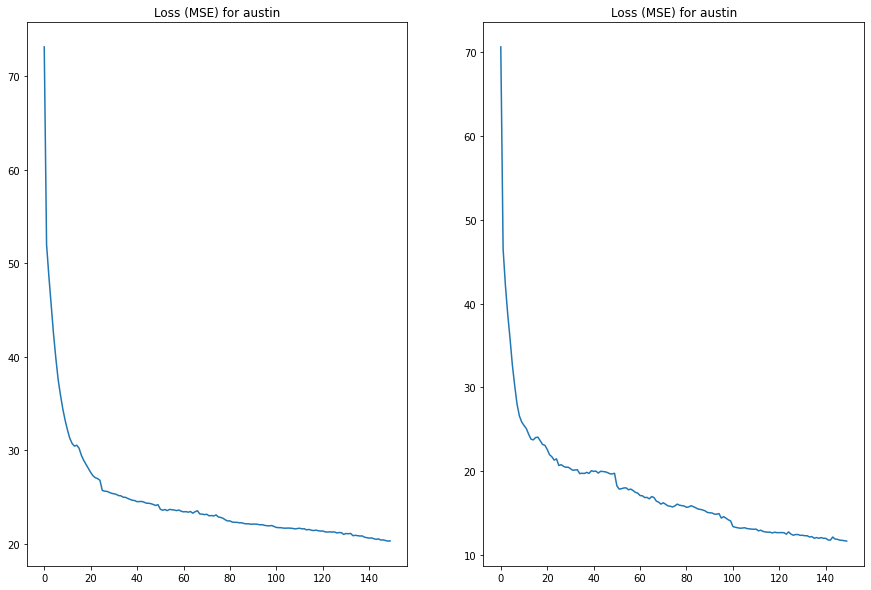

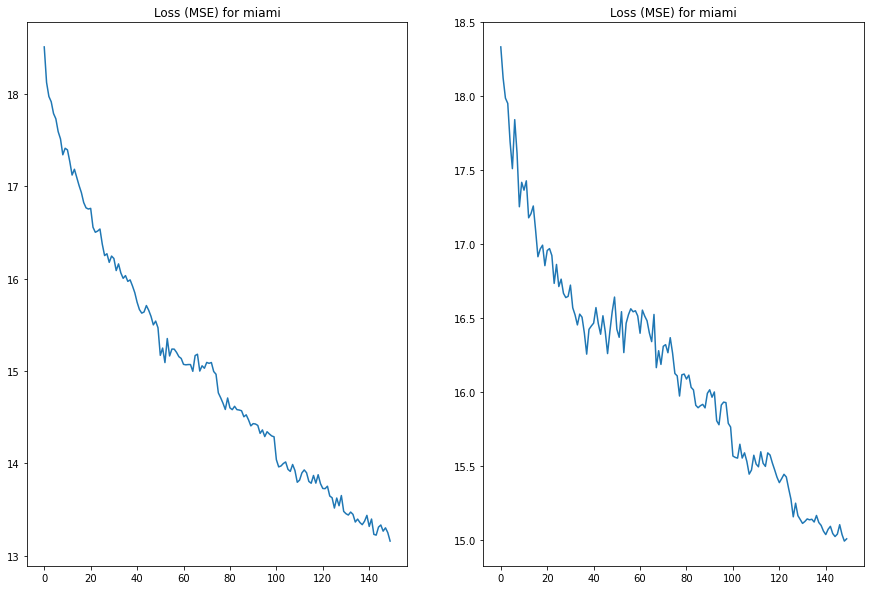

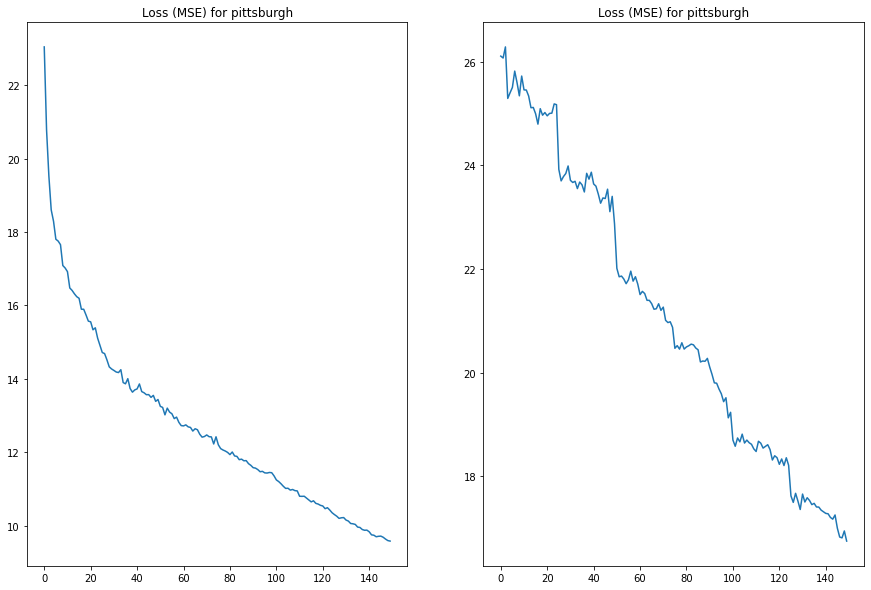

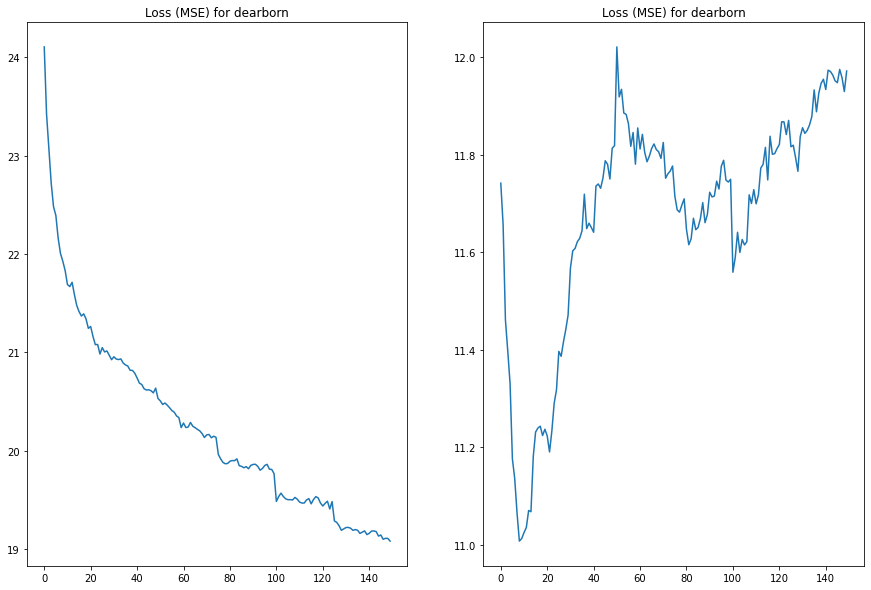

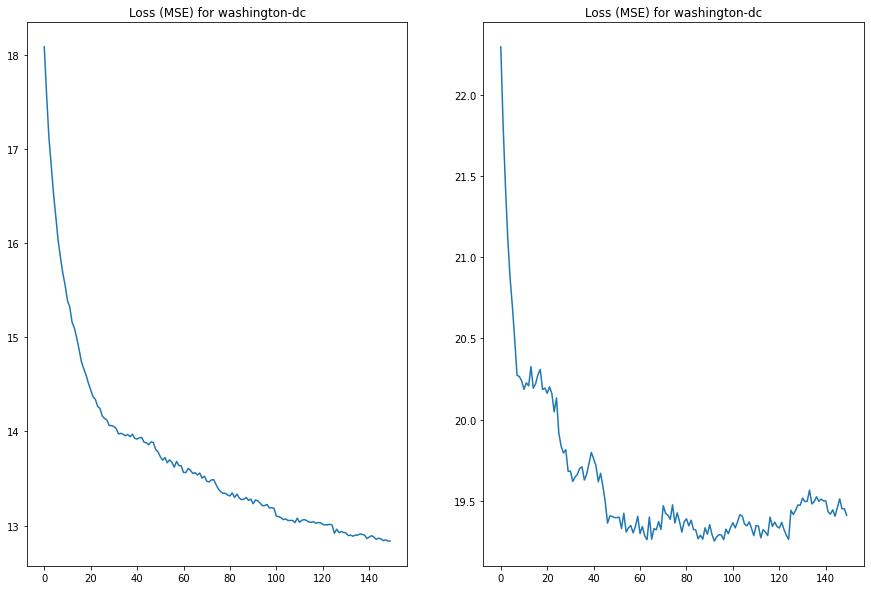

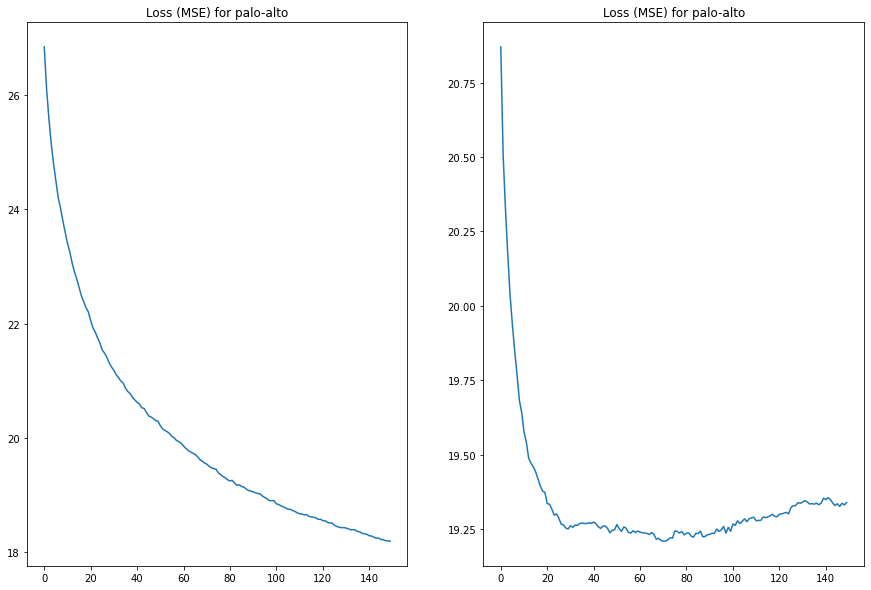

In [19]:
#model = RNN(input_size=2, hidden_size=32, output_size=2, n_layers=2, device=device, dropout=.2).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  MLP(2,128,2, device).to(device)#MLP(input_size=100, hidden_size=128, output_size=120, device=device).to(device)#Regression().to(device)
opto = torch.optim.Adam(model.parameters(), lr = .0001)
scheduler = torch.optim.lr_scheduler.StepLR(opto, 25 , gamma=0.9)
loss_fct = nn.MSELoss()
 
generate_submission('./submission.csv', model, 150, 128, opto, scheduler, loss_fct, device, valid=True)

In [ ]:
# #model = RNN(input_size=2, hidden_size=32, output_size=2, n_layers=2, device=device, dropout=.2).to(device)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = MLP(input_size=100, hidden_size=128, output_size=120, device=device).to(device)
# opto = torch.optim.Adam(model.parameters(), lr = .0001)
# scheduler = torch.optim.lr_scheduler.StepLR(opto, 100 , gamma=0.9)
# loss_fct = nn.MSELoss()
 
# generate_submission('./submission.csv', model, 300, 64, opto, scheduler, loss_fct, device, valid=True)